In [29]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [30]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 32

# Training 수
epochs = 50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

## 디렉토리 경로 설정 필요!!

In [31]:
# 디렉토리 경로 설정 필요
# CurrentDirectory = "C:/Users/sosal/.jupyter/Lectures/CNN/"
CurrentDirectory = "./"

train_directory = CurrentDirectory + 'TRAIN/'
test_directory  = CurrentDirectory + 'TEST/'
model_directory = CurrentDirectory + 'MODEL/'
tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [32]:
# # VGG_16의 구현 2016?
# def VGG_16():
#     model = Sequential()
#     # convolution / pooling의 반복
#     model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     #top layer of the VGG net
#     return model

In [33]:
# vggModel = VGG_16()
# vggModel.summary()

In [ ]:
# 모델 Return
VGGModel = tf.keras.applications.VGG16(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
# 마지막 prediction layer를 위한 작업

x = GlobalAveragePooling2D()(VGGModel.output)
# predictions = Dense(2, activation='softmax')(x)
predictions = Dense(3, activation='softmax')(x)

# Input ~ Output 연결해주기
DeepLearning = Model(inputs=VGGModel.input, outputs=predictions)

# learning parameter를 더하여 최종 model compile
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
) # 나이를, MSE

In [35]:
DeepLearning.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [47]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [48]:
# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "training")

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode="categorical",
    subset = "validation")

# Generator의 instance 생성 (Test)
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode='categorical')

Found 719 images belonging to 3 classes.
Found 79 images belonging to 3 classes.
Found 106 images belonging to 3 classes.


In [45]:
!conda install -c apple tensorflow-deps

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [41]:
!pip3 install tensorflow-macos

In [43]:
!pip install tensorflow-metal

In [46]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [40]:
!conda env list

# conda environments:
#
                         /Users/krc/miniforge3/envs/newwindow
base                     /opt/homebrew/Caskroom/miniforge/base
fastcampus               /opt/homebrew/Caskroom/miniforge/base/envs/fastcampus
pycaret                  /opt/homebrew/Caskroom/miniforge/base/envs/pycaret
pycaret2                 /opt/homebrew/Caskroom/miniforge/base/envs/pycaret2
pycaret3                 /opt/homebrew/Caskroom/miniforge/base/envs/pycaret3
tensorflow            *  /opt/homebrew/Caskroom/miniforge/base/envs/tensorflow



In [49]:
# Call-back 함수

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath=model_directory+'VGG19-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# 학습과정 진행사항 확인
TB = TensorBoard(log_dir=tensorboard_directory, write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, TB, LR]

In [51]:
########## Training Start
DeepLearning.fit_generator(
        TRAIN_GENERATOR,
        # 데이터가 너무 클 경우 1-epoch을 못하는 경우
        #steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
        
        epochs=15,
        callbacks=CALLBACK,
        shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
        validation_data=VALID_GENERATOR)
###########

/var/folders/fb/fgwpc_kd3dxdcfsnm_9w3wv40000gn/T/ipykernel_35601/1291605744.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  DeepLearning.fit_generator(


Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 0.6367 - acc: 0.6667 
Epoch 1: val_acc did not improve from 0.66667
23/23 [==============================] - 267s 12s/step - loss: 0.6367 - acc: 0.6667 - val_loss: 0.6367 - val_acc: 0.6667 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 0.6367 - acc: 0.6667 
Epoch 2: val_acc did not improve from 0.66667
23/23 [==============================] - 273s 12s/step - loss: 0.6367 - acc: 0.6667 - val_loss: 0.6368 - val_acc: 0.6667 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 0.6367 - acc: 0.6667 
Epoch 3: val_acc did not improve from 0.66667
23/23 [==============================] - 274s 12s/step - loss: 0.6367 - acc: 0.6667 - val_loss: 0.6367 - val_acc: 0.6667 - lr: 0.0010
Epoch 4/15
23/23 [==============================] - ETA: 0s - loss: 0.6366 - acc: 0.6667 
Epoch 4: val_acc did not improve from 0.66667

Epoch 4: ReduceLROnPlateau reducing learning rate to 

KeyboardInterrupt: 

In [31]:
# 학습하지 않았으므로, 강사가 학습한 모델 사용
DeepLearning.load_weights(model_directory+'PretrainedVGG.hdf5')

In [32]:
DeepLearning.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [33]:
# Prediction
TEST_Prediction = DeepLearning.predict_generator(TEST_GENERATOR, verbose=1)

C:\Users\admin\AppData\Local\Temp\ipykernel_18680\324675668.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction = DeepLearning.predict_generator(TEST_GENERATOR, verbose=1)
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2/2 [==============================] - 9s 4s/step


In [34]:
# data frame으로 변환
Result = pd.DataFrame(TEST_Prediction)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

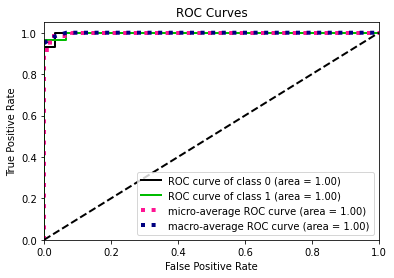

In [116]:
skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result)

In [39]:
# 다음과 같이 Back-bone model만 수정할 수 있다.
'''

Model = tf.keras.applications.VGG16(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)

Model = tf.keras.applications.ResNet101V2(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)

Model = tf.keras.applications.EfficientNetB4(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
    
'''

https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=ko

# GradCam visualization 시각화 Heatmap

In [119]:
import PIL

def grad_cam(model, img, layer_name="block5_conv3", label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.Model(inputs=[model.inputs], outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap), predictions

def grad_camAll(model, img, layer_name="conv4_block6_out", blockSize=7, label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    res = sp.ndimage.zoom(conv_output[0], (224/blockSize, 224/blockSize, 1), order=2)   
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, res), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap)

def show_imgwithheat(img_path, heatmap, alpha=0.4, return_array=False):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = PIL.Image.fromarray(superimposed_img)  
    display(imgwithheat)

    if return_array:
        return superimposed_img

In [120]:
# CAM Generator
CAM_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = 1,
    shuffle = False,
    class_mode='binary')

Found 60 images belonging to 2 classes.


In [121]:
DeepLearning.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [123]:
for Iterator in range(0, 20):
    Image, Label = CAM_GENERATOR.next()
    Image = Image[0]
    FileName = CAM_GENERATOR.filenames[Iterator]
    # Final Layer
    HEATMAP1, pred1 = grad_cam(model = DeepLearning, img = Image, layer_name = 'block5_conv3', category_id=0)
    
    heatmap1 = cv2.resize(HEATMAP1, (Image.shape[1], Image.shape[0]))
    heatmap1 = (heatmap1*255).astype("uint8")
    heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)

    fig, ax = plt.subplots( nrows=3, ncols=1 )  # create figure & 1 axis
    fig.set_size_inches(9.0, 3.0)
    ax = plt.subplot(1,3,1)
    ax.imshow(Image)
    ax = plt.subplot(1,3,2)
    ax.imshow(Image)
    ax.imshow(255-heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
    ax = plt.subplot(1,3,3)
    ax.imshow(Image)
    ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )

    plt.subplots_adjust(left = 0.06, wspace = 0.25, hspace = 0.1, bottom = 0.025, top = 0.975)
    pred=round(pred1.numpy()[0][0],3)
    HeatImage = "HEATMAP/0420_"+CAM_GENERATOR.filenames[Iterator].split('\\')[1] + "^" + str(round(pred, 4)) + ".jpg"
    plt.savefig(HeatImage.strip(), bbox_inches = 'tight')
    plt.close()
    plt.cla()
    plt.clf()

<Figure size 432x288 with 0 Axes>